In [2]:
import pandas as pd
data = pd.read_csv("crocodile_dataset.csv")
# Вивести назви колонок
print("Назви колонок:")
print(data.columns.tolist())

# Вивести розмір датасета (рядки, колонки)
print("\nРозмір датасета:")
print(data.shape)

Назви колонок:
['Observation ID', 'Common Name', 'Scientific Name', 'Family', 'Genus', 'Observed Length (m)', 'Observed Weight (kg)', 'Age Class', 'Sex', 'Date of Observation', 'Country/Region', 'Habitat Type', 'Conservation Status', 'Observer Name', 'Notes']

Розмір датасета:
(1000, 15)


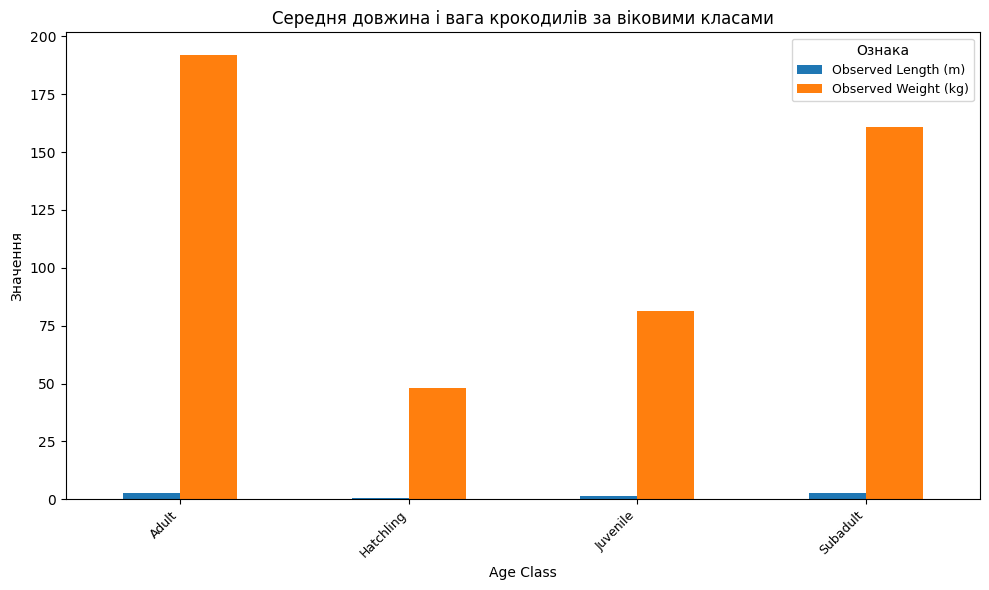

In [3]:
import matplotlib.pyplot as plt

# Групуємо по віку
grouped_age = data.groupby("Age Class")[["Observed Length (m)", "Observed Weight (kg)"]].mean()

# Будуємо графік
ax = grouped_age.plot(kind="bar", figsize=(10,6))

plt.title("Середня довжина і вага крокодилів за віковими класами")
plt.ylabel("Значення")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.legend(title="Ознака", fontsize=9)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Беремо тільки довжину і вагу
X = data[["Observed Length (m)", "Observed Weight (kg)"]]

# Нормалізація в діапазон [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Створюємо новий DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=["Length_norm", "Weight_norm"])

print(X_scaled.head())

# Додаємо до основних даних
data[["Length_norm", "Weight_norm"]] = X_scaled

# Перевіримо кореляцію після нормалізації
print("\nКореляція між нормалізованими довжиною і вагою:")
print(data[["Length_norm", "Weight_norm"]].corr())


   Length_norm  Weight_norm
0     0.294314     0.050735
1     0.660535     0.290760
2     0.157191     0.100238
3     0.381271     0.075751
4     0.603679     0.233418

Кореляція між нормалізованими довжиною і вагою:
             Length_norm  Weight_norm
Length_norm     1.000000     0.843435
Weight_norm     0.843435     1.000000


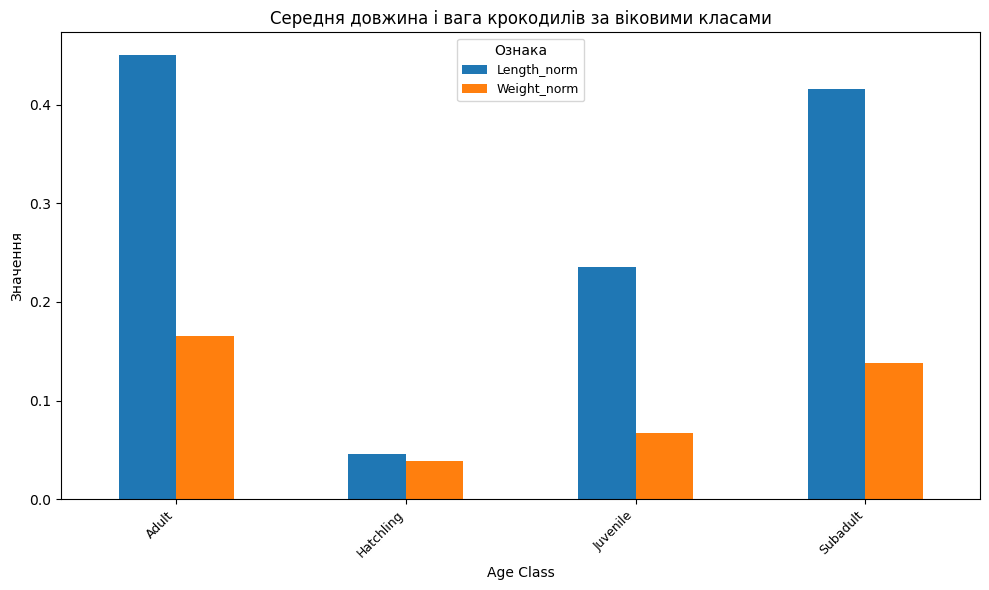

In [12]:
import matplotlib.pyplot as plt

# Групуємо по країні та статі
grouped_age = data.groupby("Age Class")[["Length_norm", "Weight_norm"]].mean()

# Будуємо графік
ax = grouped_age.plot(kind="bar", figsize=(10,6))

plt.title("Середня довжина і вага крокодилів за віковими класами")
plt.ylabel("Значення")
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.legend(title="Ознака", fontsize=9)
plt.tight_layout()
plt.show()


Основні параметри для kNN:

n_neighbors (k)
Скільки найближчих сусідів враховувати при прогнозі. малий k (наприклад 1–3) → модель дуже чутлива до шуму; великий k (15–25) → більш гладка, але може «переплющувати» менші класи.

weights
"uniform" → усі сусіди мають однакову вагу;
"distance" → ближчі сусіди важливіші.
Зазвичай "distance" допомагає, якщо класи перекриваються.

p (метрика відстані)
p=2 → Евклідова відстань (звичайна геометрична);
p=1 → Манхеттенська відстань (міська сітка).
Якщо фічі не дуже корельовані - Манхеттен може бути кращим.

Найкращі параметри: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
CV macro-F1 (best): 0.68

== Test metrics ==
Accuracy: 0.66
Macro F1: 0.689

Classification report:
              precision    recall  f1-score   support

       Adult       0.67      0.84      0.75       102
   Hatchling       1.00      1.00      1.00        10
    Juvenile       0.85      0.59      0.70        39
    Subadult       0.37      0.27      0.31        49

    accuracy                           0.66       200
   macro avg       0.72      0.67      0.69       200
weighted avg       0.65      0.66      0.64       200



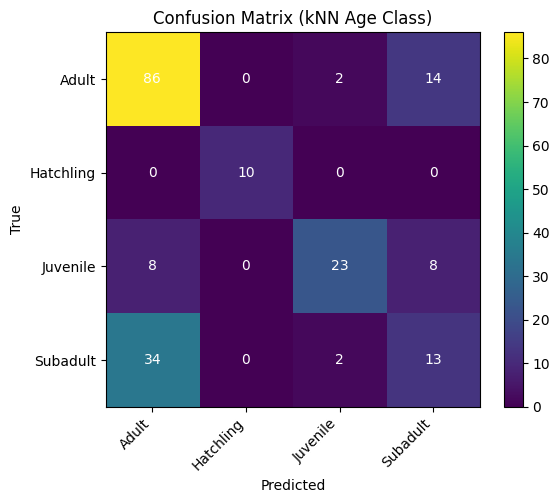

In [8]:
# === KNN: передбачення Age Class за довжиною та вагою ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Вибираємо тільки потрібні ознаки
X = data[["Observed Length (m)", "Observed Weight (kg)"]].copy()
y = data["Age Class"].astype(str).fillna("Unknown")

# 2) Кодуємо y (Age Class)
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 4) Пайплайн з нормалізацією 
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# 5) GridSearch для підбору k
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Манхеттен або Евклід
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=param_grid,
                    scoring="f1_macro", cv=cv, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

print("Найкращі параметри:", grid.best_params_)
print("CV macro-F1 (best):", round(grid.best_score_, 3))

# 6) Оцінка на тесті
best_model = grid.best_estimator_
y_pred_enc = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred_enc)
f1m = f1_score(y_test, y_pred_enc, average="macro", zero_division=0)

print("\n== Test metrics ==")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(f1m, 3))

# Декодуємо для звіту
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_enc)

print("\nClassification report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

# 7) Confusion matrix
labels = list(class_names)
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (kNN Age Class)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

=== Baseline Decision Tree ===
Accuracy: 0.6
Macro F1: 0.623

Classification report:
               precision    recall  f1-score   support

       Adult       0.69      0.67      0.68       102
   Hatchling       0.71      1.00      0.83        10
    Juvenile       0.61      0.64      0.62        39
    Subadult       0.37      0.35      0.36        49

    accuracy                           0.60       200
   macro avg       0.60      0.66      0.62       200
weighted avg       0.60      0.60      0.60       200


=== Tuned Decision Tree ===
Найкращі параметри: {'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_leaf': 10}
CV macro-F1 (best): 0.653

== Test metrics ==
Accuracy: 0.615
Macro F1: 0.62

Classification report:
               precision    recall  f1-score   support

       Adult       0.69      0.74      0.71       102
   Hatchling       0.71      1.00      0.83        10
    Juvenile       0.58      0.56      0.57        39
    Subadult       0.40      0.33 

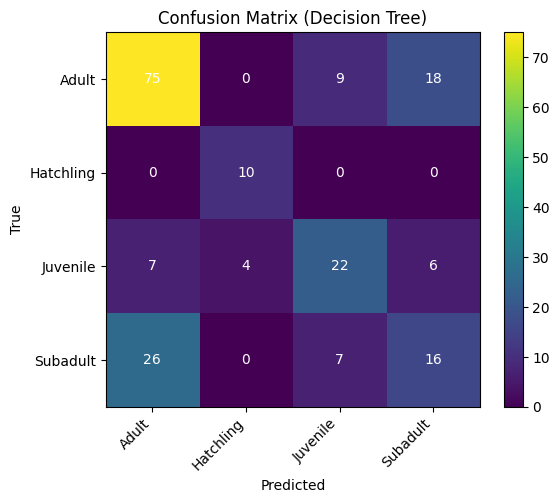

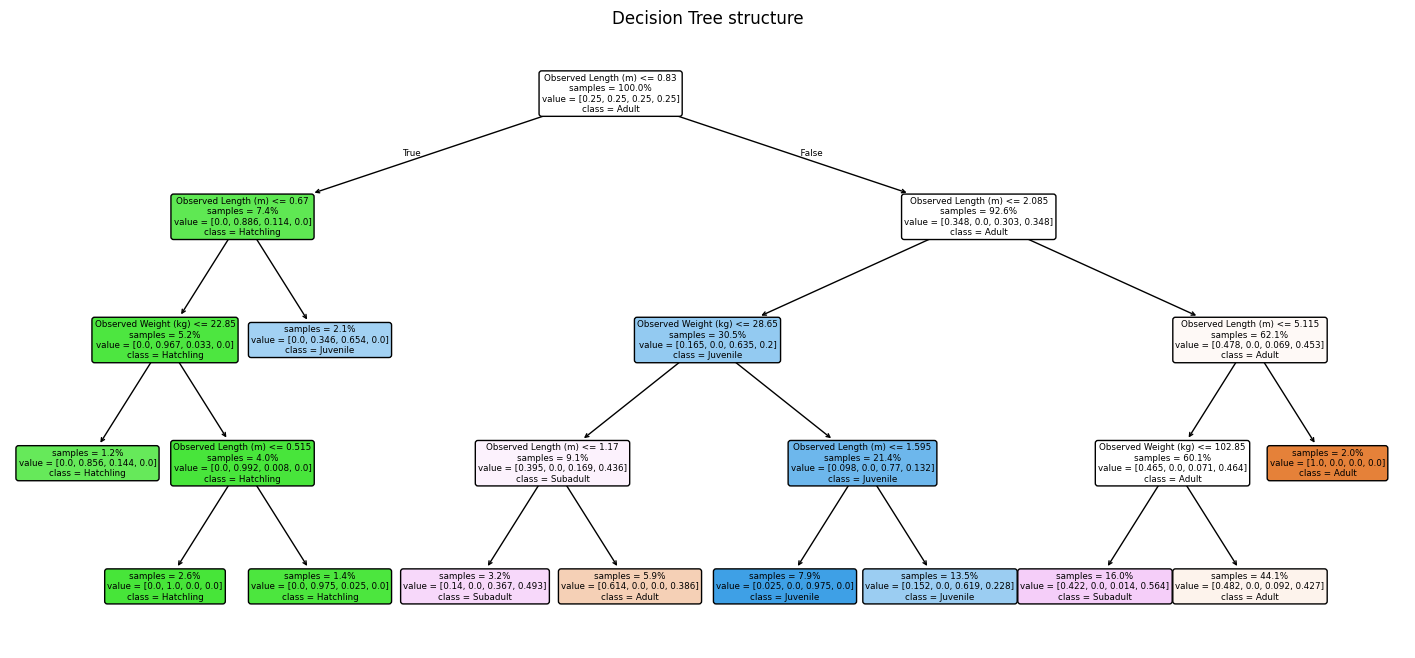


Важливість ознак (feature_importances_):
Observed Length (m)     0.930473
Observed Weight (kg)    0.069527
dtype: float64


In [12]:
# === Decision Tree: predict Age Class from Length & Weight ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Дані: 
df = data.copy()
num_cols = ["Observed Length (m)", "Observed Weight (kg)"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

feat_names = num_cols
X = df[feat_names]
y = df["Age Class"].astype(str).fillna("Unknown")

# 2) Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Бейслайн дерево 
base_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("dt", DecisionTreeClassifier(
        criterion="gini",
        max_depth=4,          # щоби було читабельно
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42
    ))
])

base_pipe.fit(X_train, y_train)
y_pred_base = base_pipe.predict(X_test)
print("=== Baseline Decision Tree ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_base), 3))
print("Macro F1:", round(f1_score(y_test, y_pred_base, average="macro", zero_division=0), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred_base, zero_division=0))

# 4) Невеликий GridSearch (швидкий, не зависає)
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("dt", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

param_grid = {
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": [3, 4, 5, 6],
    "dt__min_samples_leaf": [1, 3, 5, 10]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro", cv=cv, n_jobs=1, refit=True, verbose=0
)

grid.fit(X_train, y_train)
best = grid.best_estimator_
y_pred = best.predict(X_test)

print("\n=== Tuned Decision Tree ===")
print("Найкращі параметри:", grid.best_params_)
print("CV macro-F1 (best):", round(grid.best_score_, 3))
print("\n== Test metrics ==")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Macro F1:", round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# 5) Матриця 
labels = sorted(list(y.unique()))
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (Decision Tree)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# 6) Візуалізація дерева (краще тримати глибину <=5)
dt = best.named_steps["dt"]
plt.figure(figsize=(18, 8))
plot_tree(
    dt,
    feature_names=feat_names,
    class_names=labels,
    filled=True, rounded=True,
    impurity=False, proportion=True
)
plt.title("Decision Tree structure")
plt.show()

# 7) Важливість ознак
importances = pd.Series(dt.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nВажливість ознак (feature_importances_):")
print(importances)

Це — візуалізація дерева рішень (Decision Tree), яке я навчила для передбачення Age Class за довжиною/вагою.

feature ≤ threshold — умова розбиття. Якщо умова істинна → йдемо ліво, інакше → праворуч.

samples — скільки прикладів потрапило в цей вузол.

value = [n₁, n₂, n₃, n₄] — скільки прикладів кожного класу (порядок відповідає списку class_names, напр.: [Adult, Hatchling, Juvenile, Subadult]).

class = … — клас, який дерево прогнозує в цьому вузлі (зазвичай більшість).

Колір і насиченість — показують, який клас домінує в вузлі і наскільки «чистий» вузол (чим насиченіший — тим чистіший).

Листки (нижній ряд) — кінцеві рішення: після проходження умов зверху вниз потрапляєш до листка й отримуєш прогноз.

Найкращі параметри: {'svc__C': 10, 'svc__gamma': 1.0}
CV macro-F1 (best): 0.666

== Test metrics ==
Accuracy: 0.69
Macro F1: 0.747

Classification report:
              precision    recall  f1-score   support

       Adult       0.78      0.66      0.71       102
   Hatchling       0.91      1.00      0.95        10
    Juvenile       0.79      0.87      0.83        39
    Subadult       0.45      0.55      0.50        49

    accuracy                           0.69       200
   macro avg       0.73      0.77      0.75       200
weighted avg       0.71      0.69      0.69       200



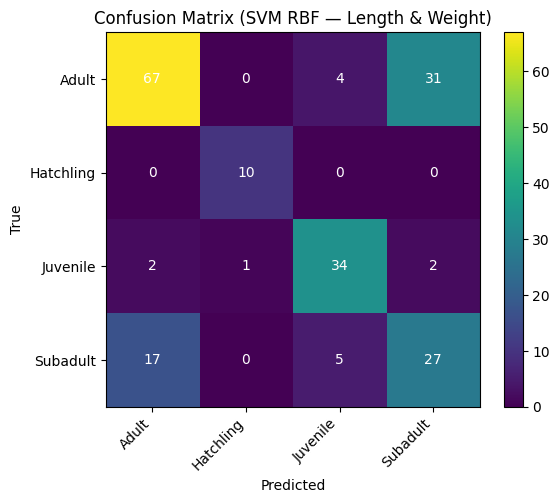

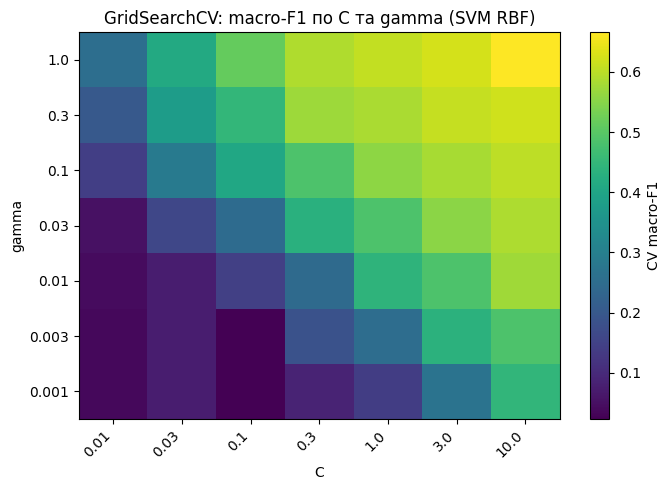

In [21]:
# === SVM (RBF): GridSearch C & gamma для передбачення Age Class ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Ознаки та ціль 
df = data.copy()
X = df[["Observed Length (m)", "Observed Weight (kg)"]].copy()
y = df["Age Class"].astype(str).fillna("Unknown")

# 2) Кодуємо ціль 
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 4) Пайплайн: імп'ютація + масштабування + SVM
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight="balanced", random_state=42))
])

# 5) GridSearch по C та gamma (лог-шкала; помірна сітка)
param_grid = {
    "svc__C":     [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    "svc__gamma": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro",
    cv=cv, n_jobs=-1, refit=True, verbose=0
)

# 6) Навчання + підбір
grid.fit(X_train, y_train)

print("Найкращі параметри:", grid.best_params_)
print("CV macro-F1 (best):", round(grid.best_score_, 3))

# 7) Оцінка на тесті
best_model = grid.best_estimator_
y_pred_enc = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred_enc)
f1m = f1_score(y_test, y_pred_enc, average="macro", zero_division=0)
print("\n== Test metrics ==")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(f1m, 3))

# Декодуємо ярлики для репорту
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_enc)

print("\nClassification report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

# 8) Матриця плутанини 
labels = class_names
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (SVM RBF — Length & Weight)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# 9) Heatmap CV-результатів C/gamma
cvres = pd.DataFrame(grid.cv_results_)
cvres["param_svc__C"] = cvres["param_svc__C"].astype(float)
cvres["param_svc__gamma"] = cvres["param_svc__gamma"].astype(float)
pivot = cvres.pivot_table(index="param_svc__gamma", columns="param_svc__C",
                          values="mean_test_score")

plt.figure(figsize=(7, 5))
im = plt.imshow(pivot.values, origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(im, label="CV macro-F1")
plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns], rotation=45, ha="right")
plt.yticks(range(len(pivot.index)),   [str(g) for g in pivot.index])
plt.xlabel("C"); plt.ylabel("gamma")
plt.title("GridSearchCV: macro-F1 по C та gamma (SVM RBF)")
plt.tight_layout(); plt.show()

Найкращі параметри: {'rf__max_depth': 16, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 400}
CV macro-F1 (best): 0.679

== Test metrics ==
Accuracy: 0.655
Macro F1: 0.679

Classification report:
              precision    recall  f1-score   support

       Adult       0.66      0.82      0.73       102
   Hatchling       0.91      1.00      0.95        10
    Juvenile       0.85      0.59      0.70        39
    Subadult       0.40      0.29      0.33        49

    accuracy                           0.66       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.65      0.66      0.64       200



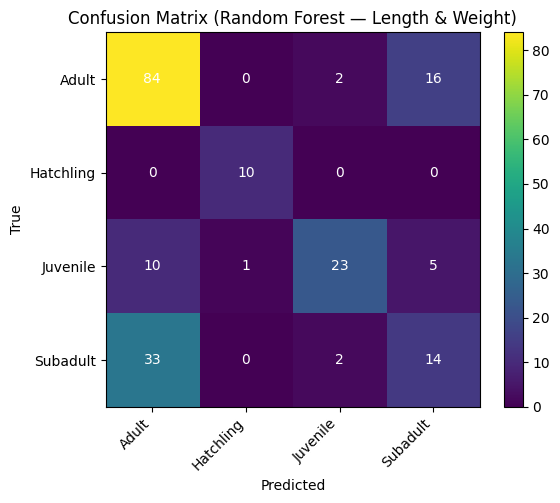


Важливість ознак:
Observed Length (m)     0.613924
Observed Weight (kg)    0.386076
dtype: float64


In [20]:
# === Random Forest: predict Age Class from Length & Weight ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Дані
df = data.copy()
num_cols = ["Observed Length (m)", "Observed Weight (kg)"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

X = df[num_cols].copy()
y = df["Age Class"].astype(str).fillna("Unknown")

# 2) Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Пайплайн: імп’ютація + RandomForest
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",   # допомагає при дисбалансі класів
        n_jobs=-1
    ))
])

# 4) Підбір гіперпараметрів (macro-F1)
param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 8, 12, 16],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_features": ["sqrt", "log2"]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro", cv=cv, n_jobs=-1, refit=True, verbose=0
)

grid.fit(X_train, y_train)

print("Найкращі параметри:", grid.best_params_)
print("CV macro-F1 (best):", round(grid.best_score_, 3))

# 5) Оцінка на тесті
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro", zero_division=0)
print("\n== Test metrics ==")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(f1m, 3))
print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 6) Confusion matrix (без seaborn)
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (Random Forest — Length & Weight)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# 7) Важливість ознак
rf = best_model.named_steps["rf"]
feat_names = num_cols  # тільки дві ознаки
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nВажливість ознак:")
print(importances)

Найкращі параметри: {'ada__estimator__max_depth': 3, 'ada__estimator__min_samples_leaf': 1, 'ada__learning_rate': 1.0, 'ada__n_estimators': 250}
CV macro-F1 (best): 0.664

== Test metrics ==
Accuracy: 0.545
Macro F1: 0.642

Classification report:
              precision    recall  f1-score   support

       Adult       0.63      0.49      0.55       102
   Hatchling       1.00      0.90      0.95        10
    Juvenile       0.69      0.64      0.67        39
    Subadult       0.33      0.51      0.40        49

    accuracy                           0.55       200
   macro avg       0.66      0.64      0.64       200
weighted avg       0.59      0.55      0.56       200



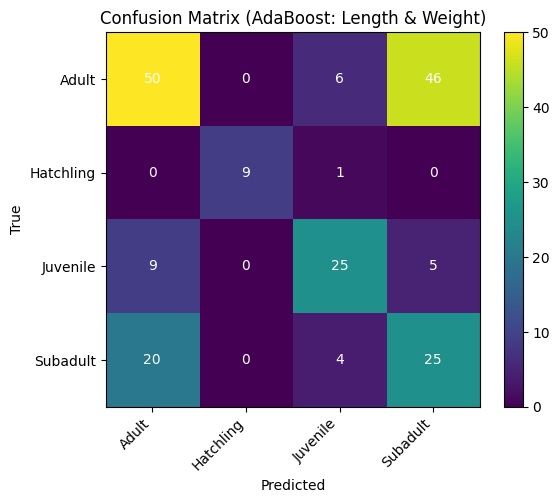


Важливість ознак (AdaBoost):
Observed Length (m)     0.533568
Observed Weight (kg)    0.466432
dtype: float64


In [22]:
# === AdaBoost: predict Age Class ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 0) Дані:
df = data.copy()
num_cols = ["Observed Length (m)", "Observed Weight (kg)"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

feat_names = num_cols
X = df[feat_names].copy()
y = df["Age Class"].astype(str).fillna("Unknown")

# 1) Кодуємо ціль
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 3) Weak learner + AdaBoost (без параметра 'algorithm' щоб не було FutureWarning)
dt_base = DecisionTreeClassifier(
    max_depth=2, min_samples_leaf=2, class_weight="balanced", random_state=42
)

ada = AdaBoostClassifier(
    estimator=dt_base,   
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("ada", ada)
])

# 4) Узгоджений param_grid для різних версій sklearn (estimator__ vs base_estimator__)
use_estimator = "estimator" in ada.get_params(deep=True).keys()
if use_estimator:
    param_grid = {
        "ada__n_estimators": [150, 250, 350],
        "ada__learning_rate": [0.25, 0.5, 1.0],
        "ada__estimator__max_depth": [1, 2, 3],
        "ada__estimator__min_samples_leaf": [1, 2, 4],
    }
else:
    param_grid = {
        "ada__n_estimators": [150, 250, 350],
        "ada__learning_rate": [0.25, 0.5, 1.0],
        "ada__base_estimator__max_depth": [1, 2, 3],
        "ada__base_estimator__min_samples_leaf": [1, 2, 4],
    }

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro", cv=cv, n_jobs=-1, refit=True, verbose=0
)

# 5) Навчання + підбір
grid.fit(X_train, y_train)

print("Найкращі параметри:", grid.best_params_)
print("CV macro-F1 (best):", round(grid.best_score_, 3))

# 6) Оцінка на тесті
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro", zero_division=0)
print("\n== Test metrics ==")
print("Accuracy:", round(acc, 3))
print("Macro F1:", round(f1m, 3))

# 7) Класифікаційний звіт (декодуємо ярлики)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification report:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

# 8) Матриця плутанини
labels = class_names
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (AdaBoost: Length & Weight)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# 9) (опційно) важливість ознак
try:
    ada_fitted = best_model.named_steps["ada"]
    fi = getattr(ada_fitted, "feature_importances_", None)
    if fi is not None:
        importances = pd.Series(fi, index=feat_names).sort_values(ascending=False)
        print("\nВажливість ознак (AdaBoost):")
        print(importances)
except Exception:
    pass

НАЙКРАЩИМ МЕТОДОМ ВИЯВИВСЯ SVM (RBF): GridSearch C & gamma для передбачення Age Class 